# Required Things;

In [1]:
import os
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-878d9b08-e6ae-919e-a853-5705837fb447)


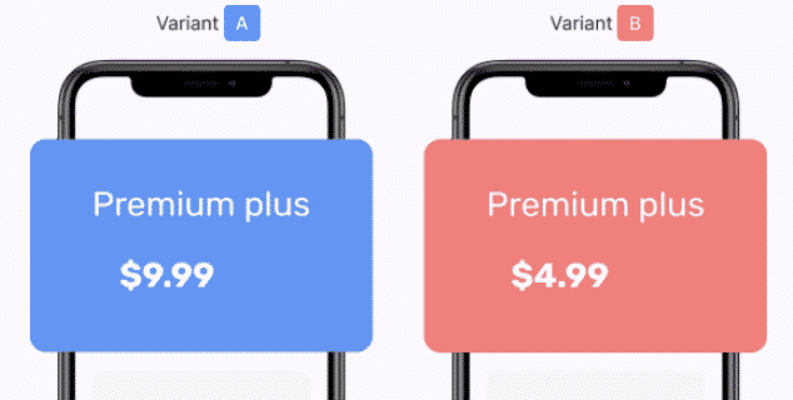

->A/B testing is essentially an experiment where two or more variants of a page are shown to users at random, and statistical analysis is used to determine which variation performs better for a given conversion goal.

->A/B testing, at its most basic, is a way to compare two versions of something to figure out which performs better.

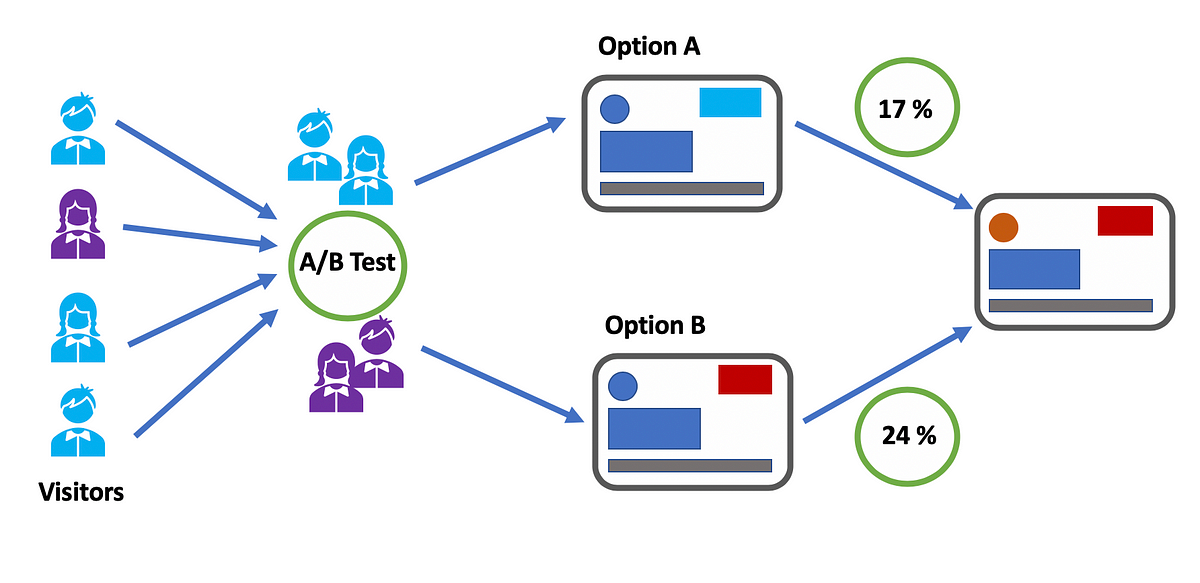

-> AB Testing Process;
 
* Understanding business problem & data
* Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
* Look summary stats and plots
* Apply hypothesis testing and check assumptions
* Check Normality & Homogeneity
* Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
* Evaluate the results
* Make inferences
* Recommend business decision to your customer/director/ceo etc.

**Import Packages-Libraries;**

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, normaltest
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

**Load The Data;**

In [5]:
df = pd.read_csv('/kaggle/input/ab-test-data/AB_Test_Results.csv')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00000
1,2423,control,0.00000
2,9411,control,0.00000
3,7311,control,0.00000
4,6174,variant,0.00000
5,2380,variant,0.00000
6,2849,control,0.00000
7,9168,control,0.00000
8,6205,variant,0.00000
9,7548,control,0.00000


Data Understanding & Summary Stats;

In [6]:
df.shape

(10000, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [8]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    
    print(" DESCRIBE ".center(70,'-'))
    print(dataframe.describe([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]).T)
    
check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 10000
Columns: 3
------------------------------- TYPES --------------------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
-------------------------------- HEAD --------------------------------
   USER_ID VARIANT_NAME  REVENUE
0      737      variant  0.00000
1     2423      control  0.00000
2     9411      control  0.00000
3     7311      control  0.00000
4     6174      variant  0.00000
-------------------------------- TAIL --------------------------------
      USER_ID VARIANT_NAME  REVENUE
9995     1981      control  0.00000
9996      502      variant  0.00000
9997     9214      variant  0.00000
9998     7741      control  0.00000
9999     9468      control  0.00000
--------------------------- MISSING VALUES ---------------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
------------------------- DUPLICATED VALUES -----------

In [9]:
# Number of Unique User
print(df['USER_ID'].nunique() == df.shape[0])

False


In [10]:
#  remove USER_ID who have two groups

duplicates = (df.groupby("USER_ID")["VARIANT_NAME"].nunique() == 1)
duplicates = duplicates[duplicates]

# USER_ID_nunique data

df = df[df["USER_ID"].isin(duplicates.index)]

In [11]:
print(" DESCRIBE ".center(70,'-'))

df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["REVENUE"]].T

------------------------------ DESCRIBE ------------------------------


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
REVENUE,6070.00000,0.10706,2.67350,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.16000,196.01000


In [12]:
df.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01000
8168,2166,control,29.32000
2482,7356,variant,23.04000
6412,1053,control,20.07000
5217,3684,variant,19.47000
5530,282,control,18.56000
758,4445,control,17.05000
4031,2059,control,14.24000
9019,1973,control,14.07000
4561,4966,variant,12.99000


In [13]:
# A/B Groups & Target Summary Stats
df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

USER_ID   REVENUE                      
             nunique       sum    mean  median count
VARIANT_NAME                                        
control         2390 470.56000 0.15551 0.00000  3026
variant         2393 179.32000 0.05891 0.00000  3044

In [14]:
# A/B Groups & Target Summary Stats
df.groupby("USER_ID")['REVENUE'].agg(["count", "median", "mean", "std", "max", 'sum']).sort_values(by='sum', ascending=False)

,count,median,mean,std,max,sum
USER_ID,,,,,,
3342,1,196.01000,196.01000,NaN,196.01000,196.01000
2166,2,14.66000,14.66000,20.73237,29.32000,29.32000
7356,1,23.04000,23.04000,NaN,23.04000,23.04000
1053,4,0.00000,5.01750,10.03500,20.07000,20.07000
3684,1,19.47000,19.47000,NaN,19.47000,19.47000
...,...,...,...,...,...,...
3363,1,0.00000,0.00000,NaN,0.00000,0.00000
3362,1,0.00000,0.00000,NaN,0.00000,0.00000
3361,1,0.00000,0.00000,NaN,0.00000,0.00000


In [15]:
# What is the confidence interval for the 'REVENUE' value?

sms.DescrStatsW(df["REVENUE"]).tconfint_mean()

(0.03979437295047436, 0.17433412787324884)

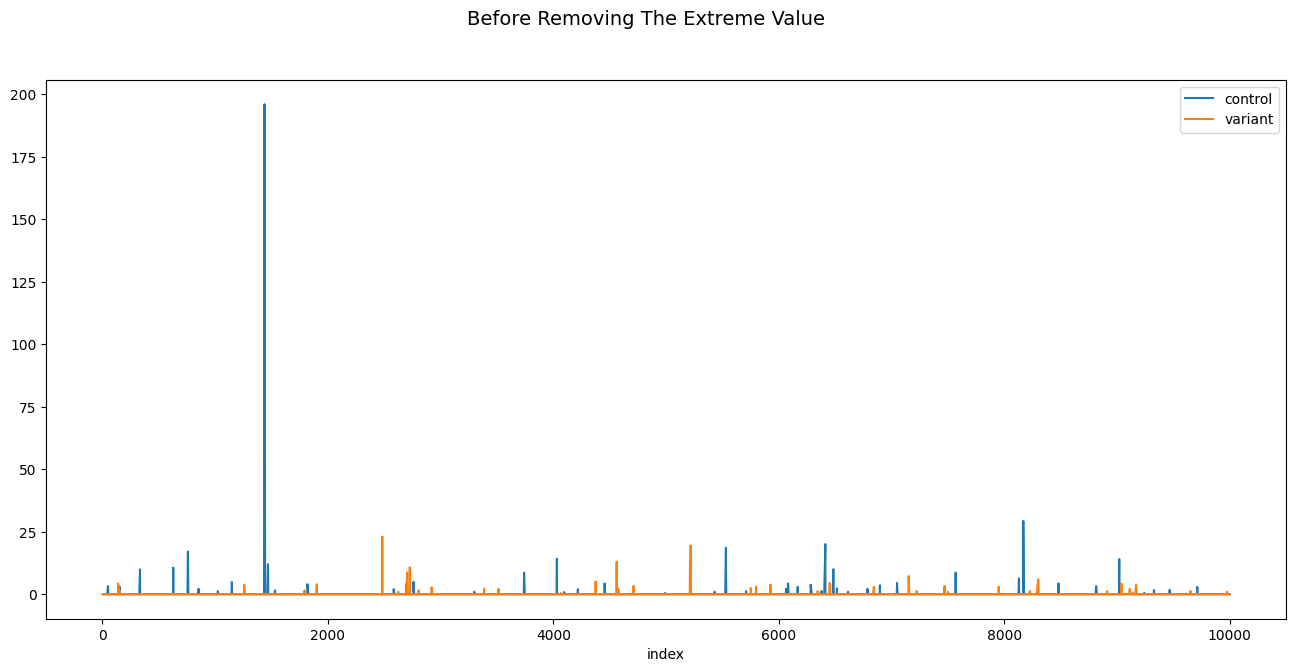

In [16]:
df[df['VARIANT_NAME'] == "control"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "control", figsize = (16,7))

df[df['VARIANT_NAME'] == "variant"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "variant")

plt.suptitle("Before Removing The Extreme Value", fontsize = 14);

In [17]:
# Gormek istemedigimiz aykiri degerleri daha sonraki islemler icin temizleyelim

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()

In [18]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "REVENUE")

In [19]:
# What is the confidence interval for the 'REVENUE' value?

sms.DescrStatsW(df["REVENUE"]).tconfint_mean()

(0.03595388879674287, 0.05730476029716157)

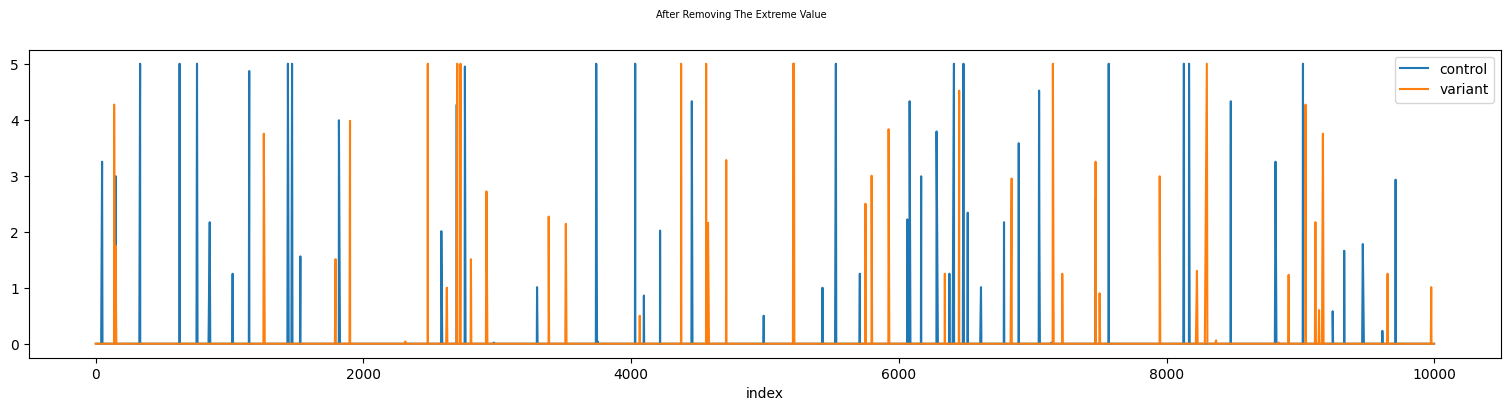

In [20]:
df[df['VARIANT_NAME'] == "control"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "control", figsize = (19,4))
df[df['VARIANT_NAME'] == "variant"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "variant")
plt.suptitle("After Removing The Extreme Value", fontsize = 7);

In [21]:
# H0: Data is a normal distribution
#->
# H1: Data is a non-normal distribution

df.groupby('VARIANT_NAME').agg({'REVENUE': ['sum', 'count']}).reset_index()

VARIANT_NAME   REVENUE      
                     sum count
0      control 165.06000  3026
1      variant 117.98000  3044

* A/B Testing;
*
*Assumptions-
 
->Check normality
* If Normal Distribution, check homogeneity

 Steps;
 
* Split & Define Control Group & Test Group
* Apply Shapiro Test for normality
* If parametric apply Levene Test for homogeneity of variances
* If Parametric + homogeneity of variances apply T-Test
* If Parametric - homogeneity of variances apply Welch Test
* If Non-parametric apply Mann Whitney U Test directly

In [22]:
def AB_Test(dataframe, group, target, A, B):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == A][target]
    groupB = dataframe[dataframe[group] == B][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

# A/B Testing;

In [23]:
AB_Test(dataframe=df, group="VARIANT_NAME", target="REVENUE", A='control', B='variant')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.24485,A/B groups are similar!


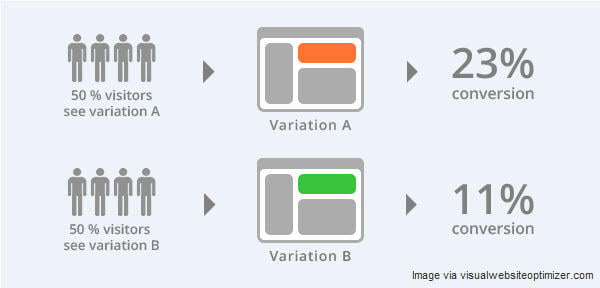

In [24]:
#